This is the simple mock galaxy catalog made of randomly shaped and placed galaxies for testing purposes

In [1]:
import ngmix
from ngmix.medsreaders import NGMixMEDS
import numpy as np
import os
import time
from astropy.table import Table, vstack, hstack


import numpy as np
import pandas as pd

import sklearn.neighbors as neighbors

from importlib import reload
import copy
import synthetic.render.generator as gen

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import synthetic.render.frame as frame

import images
import meds
import subprocess
import psfex

In [2]:
def toflux(mag):
    flux = 10**((mag - 30)/-2.5)
    return flux

In [15]:
20 * 20

400

In [16]:
np.random.seed(5000)
nobjects = 400
canvas_size = 5000
padding = 100
mock_catalog = pd.DataFrame()


x = np.linspace(padding, canvas_size - padding, 20)
y = np.linspace(padding, canvas_size - padding, 20)
xx, yy = np.meshgrid(x, y)
xx = xx.flatten()
yy = yy.flatten()


# this is something of an artifact, the X, Y is starting at 0, not at the image center... might need to be fixed
mock_catalog["X"] = xx
mock_catalog["Y"] = yy
lsizes = np.random.normal(loc=0.4, scale=0.2, size=nobjects)
mock_catalog["TSIZE"] = 10**(lsizes - 1) * 12
mock_catalog["FRACDEV"] = np.random.uniform(0, 1, size=nobjects)
mock_catalog["MAG_I"] = np.random.normal(loc=21, scale=0.5, size=nobjects)
mock_catalog["FLUX_I"] = toflux(mock_catalog["MAG_I"])
mock_catalog["G1"] = 0.3
mock_catalog["G2"] = -0.2


# ra = (mock_catalog['X'] - canvas_size) * 0.264 / 60 # arcmin
# dec = (mock_catalog['Y'] - canvas_size) * 0.264 / 60 # arcmin
# dists = np.sqrt(ra**2 + dec**2)
# shears = np.sqrt(1 / dists  / 2) # just for illustration purposes
# shears[shears > 0.8] = 0.8

# phis =  np.arctan2(dec, ra)
# es1 = (-1. * shears * np.cos(2 * phis))
# es2 = (-1. * shears * np.sin(2 * phis))
# mock_catalog["G1"] = es1
# mock_catalog["G2"] = es2

In [17]:
name = 'test_canvas_grid'
print(name)
fr = frame.Frame(mock_catalog, name=name, noise_std=1, canvas_size=canvas_size)
fr.render()
fr.extract()

test_canvas_grid
starting xshear calculations in 100 processes
sex test_canvas_grid.fits -c config.sex -CATALOG_NAME test_canvas_grid_cat.fits -CHECKIMAGE_NAME test_canvas_grid_seg.fits


In [18]:
# noise = np.random.normal(scale=fr.noise_std, size=(fr.canvas_size, fr.canvas_size))
noise = np.ones(shape=(fr.canvas_size, fr.canvas_size))
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(name + '_weight.fits', clobber=True)
# noise.array = noise
# wcanvas.setValue(noise)

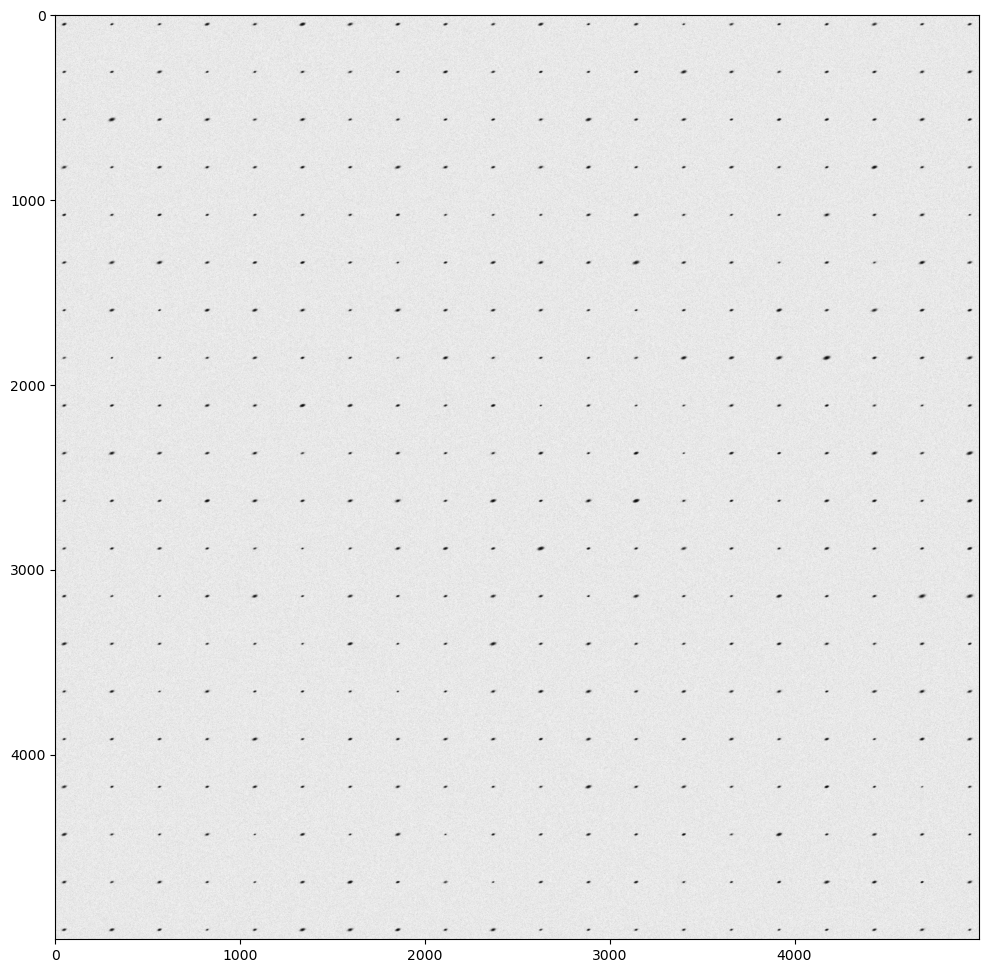

In [19]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

arr = fr.canvas.array
ax.imshow(np.arcsinh(arr) / arr, cmap=plt.cm.gray)

In [20]:
np

<module 'numpy' from '/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/numpy/__init__.py'>

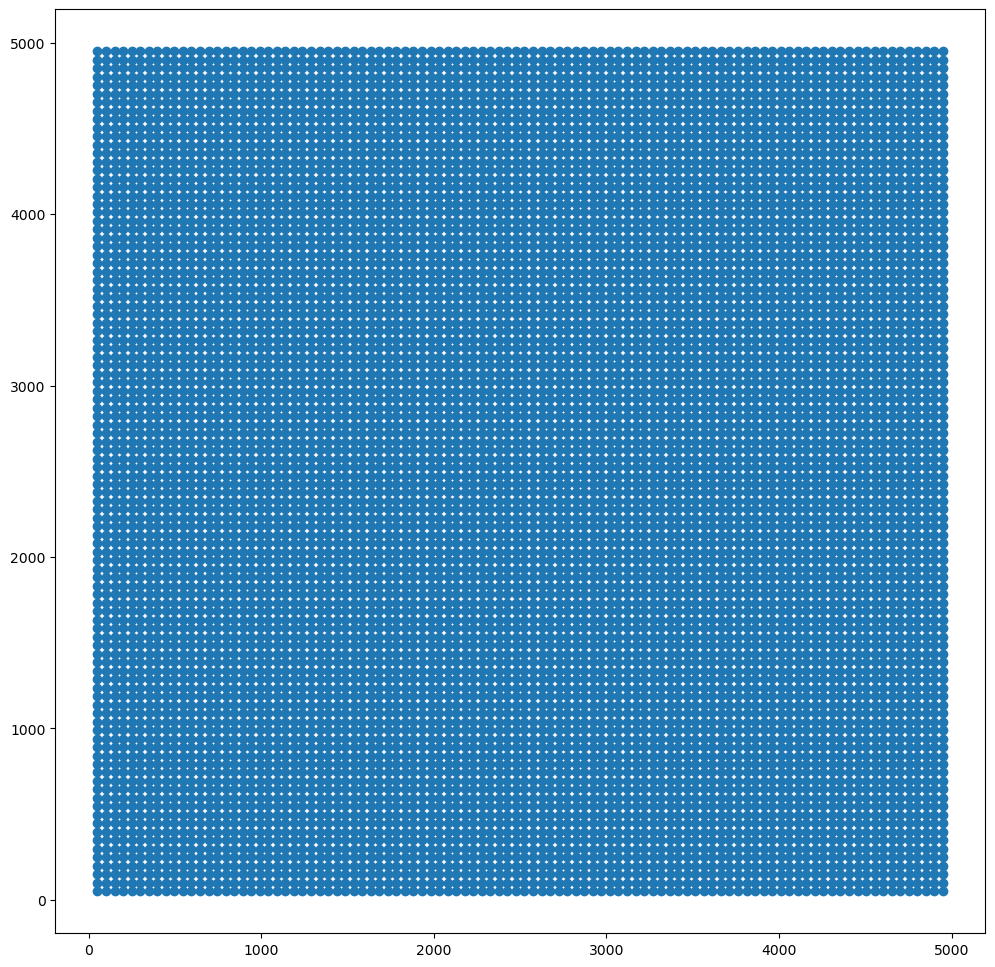

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(mock_catalog["X"], mock_catalog["Y"])

In [9]:
nimage = 1
nobj = len(fr.scat)
obj_data = meds.util.get_meds_input_struct(nobj, extra_fields=[("X_IMAGE", "f8"), ("Y_IMAGE", "f8")])
obj_data['id'] = fr.scat['NUMBER']
obj_data['box_size'] = np.ones(nobj) * 64
obj_data['ra'] = fr.scat['ALPHAWIN_J2000'] + 0.264 / 3600
obj_data['dec'] = fr.scat['DELTAWIN_J2000'] - 0.264 / 3600
obj_data['X_IMAGE'] = fr.scat['X_IMAGE']
obj_data['Y_IMAGE'] = fr.scat['Y_IMAGE']

In [10]:
image_info= meds.util.get_image_info_struct(nimage, 30)

image_info['image_path'][0] = './test_canvas_grid.fits'
image_info['weight_path'][0] = './test_canvas_grid_weight.fits' 
image_info['seg_path'][0] = './test_canvas_grid_seg.fits'
image_info['magzp'] = 30.

config = {'first_image_is_coadd': False,'cutout_types':['weight', 'seg'],'psf_type':'psfex'}

In [11]:
len('./test_canvas_grid_weight.fits' )

30

In [12]:
import psfex

# row=514.25
# col=610.00
pex = psfex.PSFEx("../meds/star_canvas_cat.psf")
# image = pex.get_rec(row, col)
psf_data = [pex,]

In [13]:
mm = meds.MEDSMaker(obj_data=obj_data, image_info=image_info, config=config, psf_data=psf_data)

writing cutouts for: ['image', 'weight', 'seg']


In [14]:
mm.write("testmeds_grid.fits")

file    1 of    1: 'b'./test_canvas_grid.fits''
    first cut:   10000 of  10000 objects
    second cut:  10000 of  10000 objects
10000/10000 had ncut > 0
setting start rows and pixel count
total pixels: 10240000
setting psf layout for PSFEx


/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/meds/util.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  phat = numpy.array([-1.0*sinp,cosp,0.0]).T


meds layout build time: 0.735054 seconds
opening output MEDS file: 'testmeds_grid.fits'
writing object_data
writing image_info
writing metadata
    reserving image mosaic
    reserving weight mosaic
    reserving seg mosaic
    reserving psf mosaic
writing image cutouts
    1/1 image b'./test_canvas_grid.fits'
    no background for image
writing weight cutouts
    1/1 weight b'./test_canvas_grid_weight.fits'
writing seg cutouts
    1/1 seg b'./test_canvas_grid_seg.fits'
writing psf cutouts
output is in: testmeds_grid.fits


In [52]:
m = meds.MEDS('testmeds_grid.fits')

In [53]:
cat = m.get_cat()

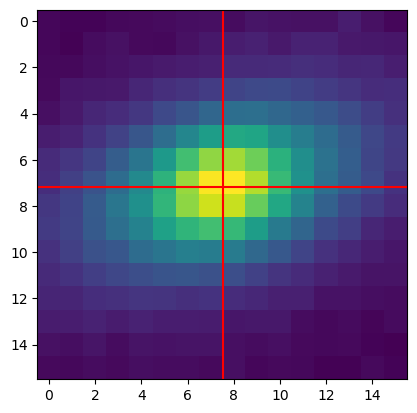

In [129]:
icut = 6231
im = m.get_cutout(icut, 0, 'image')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im)
ax.axhline(cat['cutout_row'][icut][0], color="red")
ax.axvline(cat['cutout_col'][icut][0], color="red")


# METACAL

In [56]:

class MetacalFitter(object):
    def __init__(self, medsfile, seed=None):
        self.medsfile = medsfile

        # for some reason this is bugged if you
        self.meds = NGMixMEDS(medsfile)
        self.cat = self.meds.get_cat()
        self.Nobjs = len(self.cat)

        self.set_seed(seed)

        return

    def set_seed(self, seed=None):
        if seed is None:
            # current time in microseconds
            seed = int(1e6*time.time())

        self.seed = seed

        return

    def get_obs_list(self, iobj):
        return self.meds.get_obslist(iobj)

    def get_jacobians(self, iobj):
        Njac = len(self.meds.get_jacobian_list(iobj))

        jacobians = [self.meds.get_ngmix_jacobian(iobj, icutout)
                     for icutout in range(Njac)]

        return jacobians

    def get_obj_info(self, iobj):
        '''
        Setup object property dictionary used to compile fit params later on
        '''

        obj = self.meds[iobj]

        # Mcal object properties
        obj_info = {}

        obj_info['meds_indx'] = iobj
        obj_info['id'] = obj['id']
        obj_info['ra'] = obj['ra']
        obj_info['dec'] = obj['dec']
        obj_info['X_IMAGE'] = obj['X_IMAGE']
        obj_info['Y_IMAGE'] = obj['Y_IMAGE']

        return obj_info

    def get_prior(self, pixel_scale):
        '''
        pix_scale: The pixel scale of the image, in arcsec / pixel
        '''

        # This bit is needed for ngmix v2.x.x
        # won't work for v1.x.x
        #rng = np.random.RandomState(self.seed)

        # prior on ellipticity.  The details don't matter, as long
        # as it regularizes the fit.  This one is from Bernstein & Armstrong 2014

        g_sigma = 0.3
        g_prior = ngmix.priors.GPriorBA(g_sigma)

        # 2-d gaussian prior on the center
        # row and column center (relative to the center of the jacobian, which would be zero)
        # and the sigma of the gaussians

        # units same as jacobian, probably arcsec
        row, col = 0.0, 0.0
        row_sigma, col_sigma = pixel_scale, pixel_scale # use pixel_scale as a guess
        cen_prior = ngmix.priors.CenPrior(row, col, row_sigma, col_sigma)

        # T prior.  This one is flat, but another uninformative you might
        # try is the two-sided error function (TwoSidedErf).
        # NOTE: T units are arcsec^2 but can be slightly negative, especially for
        # stars if the PSF is mis-estimated

        Tminval = -1.0 # arcsec squared
        Tmaxval = 1000
        T_prior = ngmix.priors.FlatPrior(Tminval, Tmaxval)

        # similar for flux.  Make sure the bounds make sense for
        # your images

        Fminval = -1.e1
        Fmaxval = 1.e5
        F_prior = ngmix.priors.FlatPrior(Fminval, Fmaxval)

        # now make a joint prior.  This one takes priors
        # for each parameter separately
        prior = ngmix.joint_prior.PriorSimpleSep(
            cen_prior,
            g_prior,
            T_prior,
            F_prior
            )

        return prior

    def add_mcal_responsivities(self, mcal_res, mcal_shear):
        '''
        Compute and add the mcal responsivity values to the output
        result dict from get_metacal_result()

        NOTE: These are only for the selection-independent component!
        '''

        # Define full responsivity matrix, take inner product with shear moments
        r11 = (mcal_res['1p']['g'][0] - mcal_res['1m']['g'][0]) / (2*mcal_shear)
        r12 = (mcal_res['2p']['g'][0] - mcal_res['2m']['g'][0]) / (2*mcal_shear)
        r21 = (mcal_res['1p']['g'][1] - mcal_res['1m']['g'][1]) / (2*mcal_shear)
        r22 = (mcal_res['2p']['g'][1] - mcal_res['2m']['g'][1]) / (2*mcal_shear)

        R = [ [r11, r12], [r21, r22] ]
        Rinv = np.linalg.inv(R)
        gMC = np.dot(Rinv,
                     mcal_res['noshear']['g']
                     )

        MC = {
            'r11':r11, 'r12':r12,
            'r21':r21, 'r22':r22,
            'g1_MC':gMC[0], 'g2_MC':gMC[1]
        }

        mcal_res['MC'] = MC

        return mcal_res

    def mcal_dict2tab(self, mcal, obj_info):
        '''
        mcal is the dict returned by ngmix.get_metacal_result()

        obj_info is an array with MEDS identification info like id, ra, dec
        not returned by the function
        '''

        # Annoying, but have to do this to make Table from scalars
        for key, val in obj_info.items():
            obj_info[key] = np.array([val])

        tab_names = ['noshear', '1p', '1m', '2p', '2m','MC']
        for name in tab_names:
            tab = mcal[name]

            for key, val in tab.items():
                tab[key] = np.array([val])

            mcal[name] = tab

        id_tab = Table(data=obj_info)

        tab_noshear = Table(mcal['noshear'])
        tab_1p = Table(mcal['1p'])
        tab_1m = Table(mcal['1m'])
        tab_2p = Table(mcal['2p'])
        tab_2m = Table(mcal['2m'])
        tab_MC = Table(mcal['MC'])

        join_tab = hstack([id_tab, hstack([tab_noshear,
                                           tab_1p,
                                           tab_1m,
                                           tab_2p,
                                           tab_2m,
                                           tab_MC
                                           ],
                                          table_names=tab_names)
                           ]
                          )

        return join_tab

    def fit_obj(self, iobj, pars=None, ntry=4, psf_model='gauss',
                gal_model='gauss', vb=False):
        '''
        Run metacal fit for a single object of given index

        pars: mcal running parameters
        '''

        obj_info = self.get_obj_info(iobj)

        # Fits need a list of ngmix.Observation objects
        obs_list = self.get_obs_list(iobj)

        # Get pixel scale from image jacobian
        jac_list = self.get_jacobians(iobj)
        pixel_scale = jac_list[0].get_scale()

        if pars is None:
            # standard mcal run parameters
            mcal_shear = 0.01
            lm_pars = {'maxfev':2000, 'xtol':5.0e-5, 'ftol':5.0e-5}
            max_pars = {'method':'lm', 'lm_pars':lm_pars, 'find_center':True}
            metacal_pars = {'step':mcal_shear}
        else:
            mcal_shear = metacal_pars['step']
            max_pars = pars['max_pars']
            metacal_pars = pars['metacal_pars']

        prior = self.get_prior(pixel_scale)

        Tguess = 4*pixel_+scale**2

        # setup run bootstrapper
        mcb = ngmix.bootstrap.MaxMetacalBootstrapper(obs_list)

        # Run the actual metacalibration step on the observed source
        mcb.fit_metacal(psf_model, gal_model, max_pars, Tguess, prior=prior,
                        ntry=ntry, metacal_pars=metacal_pars)

        mcal_res = mcb.get_metacal_result() # this is a dict

        # Add selection-independent responsitivities
        mcal_res = self.add_mcal_responsivities(mcal_res, mcal_shear)

        if vb is True:
            r11 = mcal_res['MC']['r11']
            r22 = mcal_res['MC']['r22']
            print(f'i={iobj}: R11: {r11:.3}; R22: {r22:.3} ')

        mcal_tab = self.mcal_dict2tab(mcal_res, obj_info)

        return mcal_tab


In [57]:
fr.scat.shape

(10000,)

In [139]:
ngmix

<module 'ngmix' from '/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ngmix/__init__.py'>

In [136]:
ngmix.__version__

'v1.3.0'

In [137]:
import ngmixer

In [138]:
ngmixer.__version__

'v0.9.8'

In [110]:

medsfile = "testmeds_grid.fits"
# medsfile = "gauss_uberseg_meds.fits.fz"
outfile = "metacal_grid.fits"
outdir = None
start = None
end = 10000
clobber = True
vb = True #args.vb # if True, prints out values of R11/R22 for every galaxy

if outdir is not None:
    outfile = os.path.join(outdir, outfile)

fitter = MetacalFitter(medsfile)

if start is None:
    start = 0
if end is None:
    end = fitter.Nobjs

# Can set mcal parameters here if you want something beyond the default
# in fit_obj()
pars = None

Tstart = time.time()

mcal_tab = []
for iobj in range(start, end):
    mcal_tab.append(
        fitter.fit_obj(iobj, pars=pars, vb=vb)
        )

mcal_tab = vstack(mcal_tab)

Tend = time.time()

T = Tend - Tstart
print(f'Total fitting and stacking time: {T} seconds')

if vb is True:
    print(f'Writing out mcal results to {outfile}...')
mcal_tab.write(outfile, overwrite=clobber)

if vb is True:
    print('Done!')



i=0: R11: 0.764; R22: 0.785 
i=1: R11: 0.767; R22: 0.797 
i=2: R11: 0.745; R22: 0.776 
i=3: R11: 0.957; R22: 0.939 
i=4: R11: 0.92; R22: 0.927 
i=5: R11: 0.806; R22: 0.818 
i=6: R11: 1.01; R22: 0.951 
i=7: R11: 0.985; R22: 0.921 
i=8: R11: 0.892; R22: 0.876 
i=9: R11: 0.734; R22: 0.781 
i=10: R11: 1.02; R22: 0.964 
i=11: R11: 0.756; R22: 0.809 
i=12: R11: 0.771; R22: 0.811 
i=13: R11: 0.843; R22: 0.872 
i=14: R11: 0.781; R22: 0.795 
i=15: R11: 0.774; R22: 0.835 
i=16: R11: 0.985; R22: 0.937 
i=17: R11: 0.97; R22: 0.932 
i=18: R11: 0.734; R22: 0.827 
i=19: R11: 0.723; R22: 0.751 
i=20: R11: 0.759; R22: 0.816 
i=21: R11: 0.78; R22: 0.767 
i=22: R11: 1.08; R22: 0.864 
i=23: R11: 0.784; R22: 0.83 
i=24: R11: 0.78; R22: 0.776 
i=25: R11: 0.763; R22: 0.822 
i=26: R11: 0.999; R22: 0.94 
i=27: R11: 0.869; R22: 0.826 
i=28: R11: 0.899; R22: 0.798 
i=29: R11: 0.725; R22: 0.761 
i=30: R11: 0.801; R22: 0.856 
i=31: R11: 0.718; R22: 0.752 
i=32: R11: 0.859; R22: 0.827 
i=33: R11: 0.919; R22: 0.955 

i=272: R11: 0.778; R22: 0.818 
i=273: R11: 0.954; R22: 0.98 
i=274: R11: 0.954; R22: 0.919 
i=275: R11: 0.782; R22: 0.782 
i=276: R11: 0.902; R22: 0.907 
i=277: R11: 0.804; R22: 0.808 
i=278: R11: 0.714; R22: 0.873 
i=279: R11: 0.807; R22: 0.855 
i=280: R11: 0.833; R22: 0.888 
i=281: R11: 0.793; R22: 0.811 
i=282: R11: 0.985; R22: 0.91 
i=283: R11: 0.724; R22: 0.793 
i=284: R11: 0.823; R22: 0.799 
i=285: R11: 0.778; R22: 0.736 
i=286: R11: 0.734; R22: 0.823 
i=287: R11: 0.782; R22: 0.903 
i=288: R11: 0.868; R22: 0.893 
i=289: R11: 0.758; R22: 0.908 
i=290: R11: 0.793; R22: 0.887 
i=291: R11: 0.946; R22: 0.805 
i=292: R11: 0.791; R22: 0.807 
i=293: R11: 0.887; R22: 0.913 
i=294: R11: 0.815; R22: 0.849 
i=295: R11: 0.831; R22: 0.88 
i=296: R11: 0.876; R22: 0.985 
i=297: R11: 0.841; R22: 0.776 
i=298: R11: 0.733; R22: 0.858 
i=299: R11: 0.706; R22: 0.786 
i=300: R11: 0.766; R22: 0.8 
i=301: R11: 0.74; R22: 0.791 
i=302: R11: 1.24; R22: 0.999 
i=303: R11: 0.787; R22: 0.861 
i=304: R11: 1.0

i=540: R11: 0.751; R22: 0.79 
i=541: R11: 0.721; R22: 0.741 
i=542: R11: 0.719; R22: 0.764 
i=543: R11: 0.734; R22: 0.779 
i=544: R11: 0.807; R22: 0.837 
i=545: R11: 0.785; R22: 0.875 
i=546: R11: 0.815; R22: 0.851 
i=547: R11: 0.965; R22: 0.955 
i=548: R11: 0.83; R22: 0.866 
i=549: R11: 0.777; R22: 0.708 
i=550: R11: 0.717; R22: 0.802 
i=551: R11: 0.92; R22: 0.868 
i=552: R11: 0.837; R22: 0.856 
i=553: R11: 0.765; R22: 0.822 
i=554: R11: 0.772; R22: 0.822 
i=555: R11: 0.893; R22: 0.902 
i=556: R11: 0.748; R22: 0.788 
i=557: R11: 0.797; R22: 0.825 
i=558: R11: 0.797; R22: 0.856 
i=559: R11: 0.714; R22: 0.778 
i=560: R11: 1.09; R22: 0.953 
i=561: R11: 0.715; R22: 0.773 
i=562: R11: 1.08; R22: 0.994 
i=563: R11: 0.877; R22: 0.902 
i=564: R11: 0.798; R22: 0.764 
i=565: R11: 1.08; R22: 0.962 
i=566: R11: 0.972; R22: 0.846 
i=567: R11: 0.759; R22: 0.825 
i=568: R11: 0.897; R22: 0.952 
i=569: R11: 0.888; R22: 0.871 
i=570: R11: 0.864; R22: 0.917 
i=571: R11: 1.01; R22: 0.87 
i=572: R11: 0.86

i=808: R11: 0.909; R22: 0.89 
i=809: R11: 0.819; R22: 0.842 
i=810: R11: 0.725; R22: 0.791 
i=811: R11: 0.984; R22: 0.96 
i=812: R11: 0.786; R22: 0.821 
i=813: R11: 1.12; R22: 0.943 
i=814: R11: 0.782; R22: 0.818 
i=815: R11: 0.733; R22: 0.761 
i=816: R11: 0.918; R22: 0.935 
i=817: R11: 0.76; R22: 0.817 
i=818: R11: 0.98; R22: 0.961 
i=819: R11: 0.717; R22: 0.778 
i=820: R11: 1.23; R22: 0.996 
i=821: R11: 0.697; R22: 0.8 
i=822: R11: 0.808; R22: 0.87 
i=823: R11: 0.885; R22: 0.876 
i=824: R11: 0.888; R22: 0.794 
i=825: R11: 1.37; R22: 0.963 
i=826: R11: 0.743; R22: 0.783 
i=827: R11: 0.722; R22: 0.806 
i=828: R11: 0.737; R22: 0.798 
i=829: R11: 0.724; R22: 0.771 
i=830: R11: 0.786; R22: 0.795 
i=831: R11: 0.757; R22: 0.783 
i=832: R11: 1.09; R22: 0.93 
i=833: R11: 0.924; R22: 0.907 
i=834: R11: 0.739; R22: 0.823 
i=835: R11: 0.881; R22: 0.894 
i=836: R11: 0.892; R22: 0.92 
i=837: R11: 0.793; R22: 0.805 
i=838: R11: 0.752; R22: 0.793 
i=839: R11: 0.763; R22: 0.734 
i=840: R11: 0.865; R2

i=1074: R11: 0.907; R22: 0.985 
i=1075: R11: 0.847; R22: 0.917 
i=1076: R11: 0.896; R22: 0.805 
i=1077: R11: 0.74; R22: 0.776 
i=1078: R11: 0.814; R22: 0.768 
i=1079: R11: 0.994; R22: 1.04 
i=1080: R11: 0.77; R22: 0.859 
i=1081: R11: 0.836; R22: 0.837 
i=1082: R11: 0.85; R22: 0.781 
i=1083: R11: 0.816; R22: 0.849 
i=1084: R11: 0.702; R22: 0.813 
i=1085: R11: 0.83; R22: 0.929 
i=1086: R11: 0.817; R22: 0.814 
i=1087: R11: 0.716; R22: 0.835 
i=1088: R11: 0.781; R22: 0.883 
i=1089: R11: 0.861; R22: 0.854 
i=1090: R11: 0.832; R22: 0.934 
i=1091: R11: 0.9; R22: 0.942 
i=1092: R11: 0.809; R22: 0.946 
i=1093: R11: 0.744; R22: 0.845 
i=1094: R11: 0.792; R22: 0.845 
i=1095: R11: 0.843; R22: 0.787 
i=1096: R11: 0.709; R22: 0.839 
i=1097: R11: 0.79; R22: 0.954 
i=1098: R11: 0.799; R22: 0.792 
i=1099: R11: 0.813; R22: 0.928 
i=1100: R11: 0.896; R22: 0.847 
i=1101: R11: 0.977; R22: 0.89 
i=1102: R11: 1.08; R22: 0.979 
i=1103: R11: 0.759; R22: 0.801 
i=1104: R11: 1.0; R22: 0.924 
i=1105: R11: 1.04; R

i=1334: R11: 0.827; R22: 0.847 
i=1335: R11: 0.89; R22: 0.843 
i=1336: R11: 0.763; R22: 0.855 
i=1337: R11: 0.902; R22: 0.845 
i=1338: R11: 1.03; R22: 0.96 
i=1339: R11: 0.866; R22: 0.883 
i=1340: R11: 0.738; R22: 0.826 
i=1341: R11: 0.834; R22: 0.855 
i=1342: R11: 0.834; R22: 0.903 
i=1343: R11: 0.802; R22: 0.824 
i=1344: R11: 0.801; R22: 0.831 
i=1345: R11: 0.852; R22: 0.864 
i=1346: R11: 0.863; R22: 0.951 
i=1347: R11: 0.751; R22: 0.807 
i=1348: R11: 0.792; R22: 0.846 
i=1349: R11: 1.12; R22: 0.954 
i=1350: R11: 0.767; R22: 0.811 
i=1351: R11: 0.815; R22: 0.865 
i=1352: R11: 0.979; R22: 0.93 
i=1353: R11: 0.89; R22: 0.896 
i=1354: R11: 0.998; R22: 0.911 
i=1355: R11: 0.977; R22: 0.95 
i=1356: R11: 0.8; R22: 0.844 
i=1357: R11: 0.973; R22: 0.929 
i=1358: R11: 0.993; R22: 0.998 
i=1359: R11: 0.761; R22: 0.795 
i=1360: R11: 0.78; R22: 0.824 
i=1361: R11: 0.724; R22: 0.831 
i=1362: R11: 0.767; R22: 0.87 
i=1363: R11: 0.766; R22: 0.796 
i=1364: R11: 0.804; R22: 0.91 
i=1365: R11: 0.913; 

i=1594: R11: 0.992; R22: 0.857 
i=1595: R11: 0.948; R22: 0.946 
i=1596: R11: 0.717; R22: 0.79 
i=1597: R11: 0.657; R22: 0.831 
i=1598: R11: 0.763; R22: 0.827 
i=1599: R11: 0.811; R22: 0.835 
i=1600: R11: 0.98; R22: 0.917 
i=1601: R11: 0.841; R22: 0.87 
i=1602: R11: 1.1; R22: 0.962 
i=1603: R11: 1.15; R22: 0.972 
i=1604: R11: 1.34; R22: 1.02 
i=1605: R11: 1.31; R22: 1.0 
i=1606: R11: 0.958; R22: 0.898 
i=1607: R11: 1.08; R22: 0.982 
i=1608: R11: 0.756; R22: 0.773 
i=1609: R11: 0.973; R22: 0.965 
i=1610: R11: 0.76; R22: 0.796 
i=1611: R11: 1.05; R22: 0.91 
i=1612: R11: 0.906; R22: 0.894 
i=1613: R11: 0.976; R22: 0.922 
i=1614: R11: 0.743; R22: 0.773 
i=1615: R11: 0.931; R22: 0.886 
i=1616: R11: 0.838; R22: 0.817 
i=1617: R11: 0.966; R22: 0.962 
i=1618: R11: 1.05; R22: 0.96 
i=1619: R11: 1.22; R22: 0.957 
i=1620: R11: 0.742; R22: 0.811 
i=1621: R11: 0.749; R22: 0.82 
i=1622: R11: 0.887; R22: 0.891 
i=1623: R11: 0.807; R22: 0.842 
i=1624: R11: 0.759; R22: 0.831 
i=1625: R11: 0.768; R22: 0.

i=1853: R11: 0.972; R22: 0.922 
i=1854: R11: 0.837; R22: 0.837 
i=1855: R11: 0.885; R22: 0.956 
i=1856: R11: 0.717; R22: 0.798 
i=1857: R11: 0.991; R22: 0.907 
i=1858: R11: 1.03; R22: 0.99 
i=1859: R11: 1.05; R22: 0.951 
i=1860: R11: 0.711; R22: 0.779 
i=1861: R11: 1.0; R22: 0.987 
i=1862: R11: 0.873; R22: 0.89 
i=1863: R11: 0.716; R22: 0.807 
i=1864: R11: 0.751; R22: 0.761 
i=1865: R11: 0.795; R22: 0.844 
i=1866: R11: 0.887; R22: 0.941 
i=1867: R11: 0.836; R22: 0.87 
i=1868: R11: 0.776; R22: 0.774 
i=1869: R11: 0.744; R22: 0.799 
i=1870: R11: 0.897; R22: 0.842 
i=1871: R11: 0.751; R22: 0.73 
i=1872: R11: 0.709; R22: 0.828 
i=1873: R11: 0.833; R22: 0.9 
i=1874: R11: 0.729; R22: 0.788 
i=1875: R11: 0.795; R22: 0.846 
i=1876: R11: 0.714; R22: 0.8 
i=1877: R11: 0.708; R22: 0.804 
i=1878: R11: 0.854; R22: 0.876 
i=1879: R11: 0.757; R22: 0.788 
i=1880: R11: 0.95; R22: 0.903 
i=1881: R11: 0.846; R22: 0.786 
i=1882: R11: 0.77; R22: 0.79 
i=1883: R11: 0.821; R22: 0.891 
i=1884: R11: 0.76; R22:

i=2112: R11: 0.736; R22: 0.785 
i=2113: R11: 0.875; R22: 0.846 
i=2114: R11: 0.778; R22: 0.819 
i=2115: R11: 0.755; R22: 0.816 
i=2116: R11: 0.814; R22: 0.893 
i=2117: R11: 0.772; R22: 0.845 
i=2118: R11: 0.941; R22: 0.898 
i=2119: R11: 0.804; R22: 0.817 
i=2120: R11: 0.842; R22: 0.882 
i=2121: R11: 1.01; R22: 0.956 
i=2122: R11: 0.93; R22: 0.876 
i=2123: R11: 1.18; R22: 0.987 
i=2124: R11: 0.96; R22: 0.941 
i=2125: R11: 0.968; R22: 0.923 
i=2126: R11: 0.884; R22: 0.892 
i=2127: R11: 0.898; R22: 0.898 
i=2128: R11: 0.959; R22: 0.94 
i=2129: R11: 0.821; R22: 0.86 
i=2130: R11: 0.832; R22: 0.88 
i=2131: R11: 0.751; R22: 0.833 
i=2132: R11: 0.779; R22: 0.803 
i=2133: R11: 0.887; R22: 0.936 
i=2134: R11: 0.735; R22: 0.784 
i=2135: R11: 0.854; R22: 0.826 
i=2136: R11: 1.04; R22: 0.971 
i=2137: R11: 0.83; R22: 0.804 
i=2138: R11: 0.86; R22: 0.802 
i=2139: R11: 0.741; R22: 0.775 
i=2140: R11: 0.805; R22: 0.921 
i=2141: R11: 0.752; R22: 0.818 
i=2142: R11: 0.821; R22: 0.876 
i=2143: R11: 1.12;

i=2371: R11: 0.836; R22: 0.858 
i=2372: R11: 0.901; R22: 0.883 
i=2373: R11: 0.955; R22: 0.941 
i=2374: R11: 0.767; R22: 0.811 
i=2375: R11: 0.865; R22: 0.915 
i=2376: R11: 0.774; R22: 0.77 
i=2377: R11: 0.784; R22: 0.825 
i=2378: R11: 0.875; R22: 0.928 
i=2379: R11: 0.74; R22: 0.824 
i=2380: R11: 0.917; R22: 0.82 
i=2381: R11: 0.887; R22: 0.933 
i=2382: R11: 0.831; R22: 0.873 
i=2383: R11: 0.802; R22: 0.719 
i=2384: R11: 0.79; R22: 0.813 
i=2385: R11: 0.971; R22: 0.939 
i=2386: R11: 0.675; R22: 0.747 
i=2387: R11: 0.824; R22: 0.754 
i=2388: R11: 0.82; R22: 0.893 
i=2389: R11: 0.815; R22: 0.912 
i=2390: R11: 0.78; R22: 0.87 
i=2391: R11: 0.666; R22: 0.897 
i=2392: R11: 1.01; R22: 0.932 
i=2393: R11: 1.03; R22: 0.915 
i=2394: R11: 0.804; R22: 0.768 
i=2395: R11: 0.783; R22: 0.77 
i=2396: R11: 0.789; R22: 0.83 
i=2397: R11: 0.818; R22: 0.948 
i=2398: R11: 0.804; R22: 0.909 
i=2399: R11: 0.819; R22: 0.878 
i=2400: R11: 0.781; R22: 0.818 
i=2401: R11: 1.08; R22: 0.978 
i=2402: R11: 1.13; R

i=2631: R11: 0.877; R22: 0.908 
i=2632: R11: 0.704; R22: 0.775 
i=2633: R11: 0.741; R22: 0.858 
i=2634: R11: 0.936; R22: 0.949 
i=2635: R11: 1.11; R22: 1.01 
i=2636: R11: 0.853; R22: 0.884 
i=2637: R11: 0.859; R22: 0.844 
i=2638: R11: 0.814; R22: 0.885 
i=2639: R11: 0.953; R22: 0.915 
i=2640: R11: 0.745; R22: 0.791 
i=2641: R11: 0.818; R22: 0.862 
i=2642: R11: 0.786; R22: 0.829 
i=2643: R11: 0.774; R22: 0.811 
i=2644: R11: 1.17; R22: 0.94 
i=2645: R11: 0.95; R22: 0.972 
i=2646: R11: 0.866; R22: 0.887 
i=2647: R11: 1.0; R22: 0.907 
i=2648: R11: 0.784; R22: 0.813 
i=2649: R11: 0.972; R22: 0.994 
i=2650: R11: 0.986; R22: 0.912 
i=2651: R11: 0.876; R22: 0.905 
i=2652: R11: 0.862; R22: 0.883 
i=2653: R11: 0.794; R22: 0.825 
i=2654: R11: 0.763; R22: 0.867 
i=2655: R11: 0.798; R22: 0.827 
i=2656: R11: 0.89; R22: 0.937 
i=2657: R11: 0.697; R22: 0.821 
i=2658: R11: 1.1; R22: 0.975 
i=2659: R11: 0.765; R22: 0.899 
i=2660: R11: 0.967; R22: 0.938 
i=2661: R11: 0.923; R22: 0.931 
i=2662: R11: 0.838

i=2891: R11: 0.77; R22: 0.783 
i=2892: R11: 0.984; R22: 1.0 
i=2893: R11: 0.979; R22: 0.922 
i=2894: R11: 0.808; R22: 0.791 
i=2895: R11: 0.902; R22: 0.86 
i=2896: R11: 0.765; R22: 0.745 
i=2897: R11: 0.763; R22: 0.804 
i=2898: R11: 0.936; R22: 0.96 
i=2899: R11: 0.85; R22: 1.02 
i=2900: R11: 0.948; R22: 0.916 
i=2901: R11: 0.713; R22: 0.782 
i=2902: R11: 1.43; R22: 1.02 
i=2903: R11: 1.6; R22: 1.03 
i=2904: R11: 0.795; R22: 0.866 
i=2905: R11: 1.02; R22: 0.92 
i=2906: R11: 0.834; R22: 0.889 
i=2907: R11: 0.788; R22: 0.795 
i=2908: R11: 0.95; R22: 0.942 
i=2909: R11: 0.912; R22: 0.873 
i=2910: R11: 1.05; R22: 0.937 
i=2911: R11: 0.98; R22: 0.855 
i=2912: R11: 0.837; R22: 0.894 
i=2913: R11: 0.878; R22: 0.905 
i=2914: R11: 0.902; R22: 0.833 
i=2915: R11: 0.724; R22: 0.788 
i=2916: R11: 0.843; R22: 0.802 
i=2917: R11: 1.14; R22: 1.01 
i=2918: R11: 1.1; R22: 0.957 
i=2919: R11: 1.05; R22: 0.991 
i=2920: R11: 0.766; R22: 0.819 
i=2921: R11: 0.979; R22: 0.893 
i=2922: R11: 1.01; R22: 0.984 

i=3151: R11: 0.895; R22: 0.883 
i=3152: R11: 0.919; R22: 0.87 
i=3153: R11: 0.782; R22: 0.816 
i=3154: R11: 0.998; R22: 0.987 
i=3155: R11: 0.824; R22: 0.787 
i=3156: R11: 0.703; R22: 0.776 
i=3157: R11: 0.896; R22: 0.942 
i=3158: R11: 0.813; R22: 0.758 
i=3159: R11: 0.88; R22: 0.908 
i=3160: R11: 0.81; R22: 0.831 
i=3161: R11: 0.758; R22: 0.832 
i=3162: R11: 0.726; R22: 0.756 
i=3163: R11: 0.898; R22: 0.917 
i=3164: R11: 0.737; R22: 0.778 
i=3165: R11: 1.07; R22: 1.01 
i=3166: R11: 0.834; R22: 0.852 
i=3167: R11: 0.902; R22: 0.919 
i=3168: R11: 0.801; R22: 0.84 
i=3169: R11: 0.74; R22: 0.817 
i=3170: R11: 0.746; R22: 0.782 
i=3171: R11: 0.789; R22: 0.781 
i=3172: R11: 0.739; R22: 0.775 
i=3173: R11: 0.905; R22: 0.988 
i=3174: R11: 0.737; R22: 0.843 
i=3175: R11: 0.93; R22: 0.957 
i=3176: R11: 0.959; R22: 1.0 
i=3177: R11: 0.889; R22: 0.908 
i=3178: R11: 0.715; R22: 0.763 
i=3179: R11: 0.828; R22: 0.829 
i=3180: R11: 0.905; R22: 0.931 
i=3181: R11: 0.864; R22: 0.745 
i=3182: R11: 0.984

i=3410: R11: 0.981; R22: 0.901 
i=3411: R11: 1.08; R22: 0.998 
i=3412: R11: 0.902; R22: 0.863 
i=3413: R11: 0.755; R22: 0.778 
i=3414: R11: 0.745; R22: 0.751 
i=3415: R11: 0.752; R22: 0.802 
i=3416: R11: 0.782; R22: 0.838 
i=3417: R11: 0.741; R22: 0.829 
i=3418: R11: 0.74; R22: 0.775 
i=3419: R11: 1.15; R22: 0.954 
i=3420: R11: 1.09; R22: 0.963 
i=3421: R11: 0.882; R22: 0.888 
i=3422: R11: 0.818; R22: 0.832 
i=3423: R11: 0.799; R22: 0.819 
i=3424: R11: 0.837; R22: 0.855 
i=3425: R11: 0.963; R22: 0.935 
i=3426: R11: 0.81; R22: 0.857 
i=3427: R11: 0.737; R22: 0.78 
i=3428: R11: 0.746; R22: 0.82 
i=3429: R11: 0.941; R22: 0.963 
i=3430: R11: 0.952; R22: 0.946 
i=3431: R11: 0.989; R22: 0.925 
i=3432: R11: 0.784; R22: 0.829 
i=3433: R11: 0.758; R22: 0.802 
i=3434: R11: 1.08; R22: 0.988 
i=3435: R11: 0.95; R22: 0.876 
i=3436: R11: 1.01; R22: 1.02 
i=3437: R11: 0.783; R22: 0.855 
i=3438: R11: 0.959; R22: 0.88 
i=3439: R11: 1.1; R22: 0.935 
i=3440: R11: 1.04; R22: 0.926 
i=3441: R11: 1.11; R22:

i=3670: R11: 0.936; R22: 0.951 
i=3671: R11: 0.762; R22: 0.844 
i=3672: R11: 0.888; R22: 0.862 
i=3673: R11: 0.785; R22: 0.894 
i=3674: R11: 0.885; R22: 0.768 
i=3675: R11: 0.819; R22: 0.901 
i=3676: R11: 0.821; R22: 0.862 
i=3677: R11: 1.27; R22: 0.915 
i=3678: R11: 0.723; R22: 0.727 
i=3679: R11: 0.756; R22: 0.847 
i=3680: R11: 0.769; R22: 0.804 
i=3681: R11: 0.806; R22: 0.738 
i=3682: R11: 0.986; R22: 0.877 
i=3683: R11: 0.985; R22: 0.947 
i=3684: R11: 0.823; R22: 0.796 
i=3685: R11: 0.786; R22: 0.874 
i=3686: R11: 0.762; R22: 0.738 
i=3687: R11: 0.724; R22: 0.839 
i=3688: R11: 0.846; R22: 0.909 
i=3689: R11: 0.768; R22: 0.898 
i=3690: R11: 0.819; R22: 0.851 
i=3691: R11: 0.913; R22: 0.727 
i=3692: R11: 0.781; R22: 0.919 
i=3693: R11: 0.881; R22: 0.827 
i=3694: R11: 0.891; R22: 0.898 
i=3695: R11: 0.632; R22: 0.789 
i=3696: R11: 0.711; R22: 0.758 
i=3697: R11: 0.853; R22: 0.844 
i=3698: R11: 0.807; R22: 0.802 
i=3699: R11: 0.701; R22: 0.768 
i=3700: R11: 0.946; R22: 0.916 
i=3701: R

i=3929: R11: 0.848; R22: 0.879 
i=3930: R11: 0.979; R22: 0.947 
i=3931: R11: 0.88; R22: 0.909 
i=3932: R11: 0.747; R22: 0.806 
i=3933: R11: 0.887; R22: 0.907 
i=3934: R11: 1.07; R22: 1.01 
i=3935: R11: 0.889; R22: 0.884 
i=3936: R11: 0.854; R22: 0.836 
i=3937: R11: 0.925; R22: 0.889 
i=3938: R11: 0.961; R22: 0.964 
i=3939: R11: 0.858; R22: 0.904 
i=3940: R11: 0.785; R22: 0.806 
i=3941: R11: 1.02; R22: 0.94 
i=3942: R11: 1.03; R22: 0.962 
i=3943: R11: 0.733; R22: 0.784 
i=3944: R11: 1.03; R22: 0.946 
i=3945: R11: 0.709; R22: 0.815 
i=3946: R11: 0.779; R22: 0.86 
i=3947: R11: 0.903; R22: 0.861 
i=3948: R11: 1.24; R22: 0.944 
i=3949: R11: 0.805; R22: 0.837 
i=3950: R11: 1.15; R22: 0.962 
i=3951: R11: 1.12; R22: 1.08 
i=3952: R11: 0.856; R22: 0.848 
i=3953: R11: 0.908; R22: 0.908 
i=3954: R11: 0.822; R22: 0.859 
i=3955: R11: 0.734; R22: 0.822 
i=3956: R11: 0.732; R22: 0.817 
i=3957: R11: 0.972; R22: 0.925 
i=3958: R11: 1.04; R22: 0.933 
i=3959: R11: 0.78; R22: 0.807 
i=3960: R11: 0.793; R2

i=4189: R11: 0.777; R22: 0.729 
i=4190: R11: 0.873; R22: 0.783 
i=4191: R11: 0.763; R22: 0.887 
i=4192: R11: 0.813; R22: 0.946 
i=4193: R11: 0.792; R22: 0.749 
i=4194: R11: 0.778; R22: 0.808 
i=4195: R11: 0.821; R22: 0.849 
i=4196: R11: 0.942; R22: 0.883 
i=4197: R11: 0.696; R22: 0.755 
i=4198: R11: 0.642; R22: 0.729 
i=4199: R11: 0.787; R22: 0.878 
i=4200: R11: 1.01; R22: 0.885 
i=4201: R11: 0.848; R22: 0.858 
i=4202: R11: 0.798; R22: 0.831 
i=4203: R11: 1.05; R22: 0.97 
i=4204: R11: 0.972; R22: 0.908 
i=4205: R11: 0.763; R22: 0.808 
i=4206: R11: 0.931; R22: 0.904 
i=4207: R11: 0.915; R22: 0.894 
i=4208: R11: 0.998; R22: 0.959 
i=4209: R11: 0.903; R22: 0.866 
i=4210: R11: 1.37; R22: 1.05 
i=4211: R11: 0.771; R22: 0.792 
i=4212: R11: 1.01; R22: 0.94 
i=4213: R11: 0.898; R22: 0.905 
i=4214: R11: 0.738; R22: 0.793 
i=4215: R11: 0.811; R22: 0.82 
i=4216: R11: 0.779; R22: 0.808 
i=4217: R11: 0.812; R22: 0.86 
i=4218: R11: 0.967; R22: 0.865 
i=4219: R11: 0.915; R22: 0.891 
i=4220: R11: 0.82

i=4449: R11: 0.932; R22: 0.931 
i=4450: R11: 0.904; R22: 0.877 
i=4451: R11: 0.793; R22: 0.771 
i=4452: R11: 0.739; R22: 0.784 
i=4453: R11: 0.76; R22: 0.768 
i=4454: R11: 0.799; R22: 0.788 
i=4455: R11: 0.88; R22: 0.931 
i=4456: R11: 0.895; R22: 0.91 
i=4457: R11: 0.918; R22: 0.801 
i=4458: R11: 0.743; R22: 0.76 
i=4459: R11: 0.711; R22: 0.773 
i=4460: R11: 0.932; R22: 0.916 
i=4461: R11: 0.803; R22: 0.855 
i=4462: R11: 0.808; R22: 0.854 
i=4463: R11: 0.73; R22: 0.735 
i=4464: R11: 0.653; R22: 0.802 
i=4465: R11: 0.756; R22: 0.794 
i=4466: R11: 1.2; R22: 0.981 
i=4467: R11: 1.03; R22: 0.94 
i=4468: R11: 0.898; R22: 0.859 
i=4469: R11: 0.857; R22: 0.819 
i=4470: R11: 0.741; R22: 0.819 
i=4471: R11: 0.846; R22: 0.823 
i=4472: R11: 0.755; R22: 0.762 
i=4473: R11: 1.0; R22: 0.939 
i=4474: R11: 0.768; R22: 0.841 
i=4475: R11: 0.945; R22: 0.955 
i=4476: R11: 0.941; R22: 0.959 
i=4477: R11: 0.821; R22: 0.917 
i=4478: R11: 0.707; R22: 0.778 
i=4479: R11: 0.717; R22: 0.743 
i=4480: R11: 1.04; 

i=4709: R11: 0.862; R22: 0.858 
i=4710: R11: 0.829; R22: 0.872 
i=4711: R11: 0.996; R22: 0.964 
i=4712: R11: 1.12; R22: 0.981 
i=4713: R11: 0.81; R22: 0.847 
i=4714: R11: 0.784; R22: 0.836 
i=4715: R11: 0.849; R22: 0.799 
i=4716: R11: 0.749; R22: 0.802 
i=4717: R11: 0.88; R22: 0.865 
i=4718: R11: 0.743; R22: 0.79 
i=4719: R11: 1.18; R22: 0.97 
i=4720: R11: 0.848; R22: 0.885 
i=4721: R11: 0.739; R22: 0.798 
i=4722: R11: 0.767; R22: 0.872 
i=4723: R11: 0.829; R22: 0.88 
i=4724: R11: 0.759; R22: 0.817 
i=4725: R11: 0.969; R22: 0.918 
i=4726: R11: 0.966; R22: 0.945 
i=4727: R11: 0.979; R22: 0.9 
i=4728: R11: 0.846; R22: 0.844 
i=4729: R11: 1.13; R22: 0.946 
i=4730: R11: 0.834; R22: 0.902 
i=4731: R11: 0.81; R22: 0.82 
i=4732: R11: 1.02; R22: 0.968 
i=4733: R11: 0.763; R22: 0.769 
i=4734: R11: 0.773; R22: 0.863 
i=4735: R11: 0.76; R22: 0.824 
i=4736: R11: 0.84; R22: 0.837 
i=4737: R11: 0.798; R22: 0.799 
i=4738: R11: 0.857; R22: 0.9 
i=4739: R11: 0.725; R22: 0.769 
i=4740: R11: 0.794; R22: 

i=4969: R11: 0.782; R22: 0.806 
i=4970: R11: 0.811; R22: 0.793 
i=4971: R11: 0.928; R22: 0.915 
i=4972: R11: 0.862; R22: 0.935 
i=4973: R11: 0.794; R22: 0.826 
i=4974: R11: 0.705; R22: 0.806 
i=4975: R11: 0.943; R22: 0.924 
i=4976: R11: 0.761; R22: 0.824 
i=4977: R11: 0.889; R22: 0.905 
i=4978: R11: 0.955; R22: 0.943 
i=4979: R11: 0.837; R22: 0.925 
i=4980: R11: 0.925; R22: 0.945 
i=4981: R11: 0.766; R22: 0.836 
i=4982: R11: 0.884; R22: 0.87 
i=4983: R11: 0.768; R22: 0.722 
i=4984: R11: 0.883; R22: 0.948 
i=4985: R11: 0.794; R22: 0.823 
i=4986: R11: 0.947; R22: 0.97 
i=4987: R11: 0.983; R22: 0.942 
i=4988: R11: 0.864; R22: 0.837 
i=4989: R11: 0.835; R22: 0.908 
i=4990: R11: 1.02; R22: 0.844 
i=4991: R11: 0.882; R22: 0.844 
i=4992: R11: 0.766; R22: 0.773 
i=4993: R11: 0.742; R22: 0.792 
i=4994: R11: 0.76; R22: 0.895 
i=4995: R11: 0.725; R22: 0.711 
i=4996: R11: 0.999; R22: 0.928 
i=4997: R11: 0.739; R22: 0.77 
i=4998: R11: 0.773; R22: 0.868 
i=4999: R11: 0.811; R22: 0.932 
i=5000: R11: 

i=5228: R11: 0.999; R22: 0.967 
i=5229: R11: 0.782; R22: 0.836 
i=5230: R11: 0.866; R22: 0.911 
i=5231: R11: 0.873; R22: 0.857 
i=5232: R11: 0.756; R22: 0.791 
i=5233: R11: 1.3; R22: 0.983 
i=5234: R11: 0.935; R22: 0.923 
i=5235: R11: 0.956; R22: 0.952 
i=5236: R11: 1.01; R22: 0.976 
i=5237: R11: 1.05; R22: 0.981 
i=5238: R11: 0.799; R22: 0.787 
i=5239: R11: 0.738; R22: 0.827 
i=5240: R11: 0.827; R22: 0.858 
i=5241: R11: 0.93; R22: 0.956 
i=5242: R11: 0.941; R22: 0.904 
i=5243: R11: 0.719; R22: 0.79 
i=5244: R11: 0.802; R22: 0.857 
i=5245: R11: 0.852; R22: 0.88 
i=5246: R11: 0.75; R22: 0.799 
i=5247: R11: 0.868; R22: 0.846 
i=5248: R11: 0.825; R22: 0.846 
i=5249: R11: 0.907; R22: 0.9 
i=5250: R11: 0.776; R22: 0.804 
i=5251: R11: 0.936; R22: 0.921 
i=5252: R11: 0.842; R22: 0.909 
i=5253: R11: 0.887; R22: 0.883 
i=5254: R11: 0.781; R22: 0.768 
i=5255: R11: 0.995; R22: 0.929 
i=5256: R11: 0.754; R22: 0.784 
i=5257: R11: 0.836; R22: 0.826 
i=5258: R11: 0.909; R22: 0.949 
i=5259: R11: 0.834

i=5487: R11: 0.746; R22: 0.809 
i=5488: R11: 0.879; R22: 0.966 
i=5489: R11: 0.854; R22: 0.868 
i=5490: R11: 0.776; R22: 0.85 
i=5491: R11: 0.789; R22: 0.88 
i=5492: R11: 0.877; R22: 0.907 
i=5493: R11: 0.764; R22: 0.757 
i=5494: R11: 0.79; R22: 0.751 
i=5495: R11: 0.67; R22: 0.845 
i=5496: R11: 0.858; R22: 0.88 
i=5497: R11: 0.983; R22: 1.01 
i=5498: R11: 0.766; R22: 0.869 
i=5499: R11: 0.746; R22: 0.778 
i=5500: R11: 0.826; R22: 0.807 
i=5501: R11: 1.01; R22: 0.854 
i=5502: R11: 1.08; R22: 0.94 
i=5503: R11: 0.958; R22: 0.916 
i=5504: R11: 0.769; R22: 0.817 
i=5505: R11: 0.784; R22: 0.809 
i=5506: R11: 0.806; R22: 0.85 
i=5507: R11: 1.05; R22: 0.959 
i=5508: R11: 0.857; R22: 0.857 
i=5509: R11: 0.777; R22: 0.826 
i=5510: R11: 0.937; R22: 0.925 
i=5511: R11: 0.929; R22: 0.907 
i=5512: R11: 1.11; R22: 0.96 
i=5513: R11: 0.821; R22: 0.884 
i=5514: R11: 0.8; R22: 0.829 
i=5515: R11: 1.12; R22: 0.985 
i=5516: R11: 0.962; R22: 0.92 
i=5517: R11: 0.749; R22: 0.794 
i=5518: R11: 1.03; R22: 0

i=5747: R11: 0.911; R22: 0.939 
i=5748: R11: 0.877; R22: 0.941 
i=5749: R11: 0.819; R22: 0.849 
i=5750: R11: 0.804; R22: 0.861 
i=5751: R11: 1.01; R22: 0.984 
i=5752: R11: 0.904; R22: 0.942 
i=5753: R11: 0.78; R22: 0.844 
i=5754: R11: 0.88; R22: 0.88 
i=5755: R11: 0.809; R22: 0.818 
i=5756: R11: 0.927; R22: 0.947 
i=5757: R11: 0.801; R22: 0.808 
i=5758: R11: 0.927; R22: 0.961 
i=5759: R11: 0.933; R22: 0.976 
i=5760: R11: 0.753; R22: 0.817 
i=5761: R11: 0.789; R22: 0.715 
i=5762: R11: 0.733; R22: 0.825 
i=5763: R11: 0.748; R22: 0.8 
i=5764: R11: 0.852; R22: 0.877 
i=5765: R11: 0.934; R22: 0.94 
i=5766: R11: 0.911; R22: 0.977 
i=5767: R11: 0.866; R22: 0.914 
i=5768: R11: 0.744; R22: 0.796 
i=5769: R11: 0.95; R22: 0.971 
i=5770: R11: 0.868; R22: 0.829 
i=5771: R11: 0.791; R22: 0.843 
i=5772: R11: 0.74; R22: 0.796 
i=5773: R11: 0.855; R22: 0.87 
i=5774: R11: 0.757; R22: 0.757 
i=5775: R11: 0.823; R22: 0.89 
i=5776: R11: 0.721; R22: 0.798 
i=5777: R11: 0.844; R22: 0.858 
i=5778: R11: 0.825;

i=6007: R11: 0.921; R22: 0.95 
i=6008: R11: 0.847; R22: 0.908 
i=6009: R11: 1.08; R22: 0.938 
i=6010: R11: 0.945; R22: 0.892 
i=6011: R11: 0.773; R22: 0.797 
i=6012: R11: 0.867; R22: 0.89 
i=6013: R11: 0.775; R22: 0.816 
i=6014: R11: 0.938; R22: 0.914 
i=6015: R11: 0.897; R22: 0.895 
i=6016: R11: 0.712; R22: 0.764 
i=6017: R11: 1.05; R22: 0.927 
i=6018: R11: 0.731; R22: 0.763 
i=6019: R11: 0.882; R22: 0.918 
i=6020: R11: 0.706; R22: 0.774 
i=6021: R11: 0.841; R22: 0.794 
i=6022: R11: 1.11; R22: 0.958 
i=6023: R11: 1.14; R22: 0.978 
i=6024: R11: 0.765; R22: 0.78 
i=6025: R11: 0.79; R22: 0.839 
i=6026: R11: 0.797; R22: 0.85 
i=6027: R11: 0.937; R22: 0.886 
i=6028: R11: 1.08; R22: 0.95 
i=6029: R11: 0.976; R22: 0.887 
i=6030: R11: 0.837; R22: 0.857 
i=6031: R11: 0.792; R22: 0.783 
i=6032: R11: 0.913; R22: 0.937 
i=6033: R11: 0.866; R22: 0.906 
i=6034: R11: 0.866; R22: 0.897 
i=6035: R11: 0.864; R22: 0.835 
i=6036: R11: 0.76; R22: 0.802 
i=6037: R11: 0.954; R22: 0.936 
i=6038: R11: 0.87; R

i=6264: R11: 0.755; R22: 0.858 
i=6265: R11: 0.921; R22: 0.936 
i=6266: R11: 0.984; R22: 0.967 
i=6267: R11: 1.08; R22: 0.949 
i=6268: R11: 0.876; R22: 0.954 
i=6269: R11: 0.795; R22: 0.792 
i=6270: R11: 0.905; R22: 0.953 
i=6271: R11: 0.776; R22: 0.819 
i=6272: R11: 0.905; R22: 0.94 
i=6273: R11: 0.829; R22: 0.927 
i=6274: R11: 0.937; R22: 0.9 
i=6275: R11: 0.765; R22: 0.8 
i=6276: R11: 0.869; R22: 0.835 
i=6277: R11: 0.929; R22: 0.919 
i=6278: R11: 0.912; R22: 0.923 
i=6279: R11: 0.657; R22: 0.757 
i=6280: R11: 0.825; R22: 0.839 
i=6281: R11: 0.789; R22: 0.824 
i=6282: R11: 0.768; R22: 0.775 
i=6283: R11: 0.923; R22: 0.982 
i=6284: R11: 0.747; R22: 0.819 
i=6285: R11: 0.862; R22: 0.824 
i=6286: R11: 0.79; R22: 0.72 
i=6287: R11: 0.838; R22: 0.877 
i=6288: R11: 0.906; R22: 0.875 
i=6289: R11: 0.798; R22: 0.765 
i=6290: R11: 0.722; R22: 0.818 
i=6291: R11: 0.74; R22: 0.785 
i=6292: R11: 0.777; R22: 0.737 
i=6293: R11: 0.764; R22: 0.896 
i=6294: R11: 0.851; R22: 0.812 
i=6295: R11: 0.93

i=6519: R11: 1.06; R22: 0.977 
i=6520: R11: 0.854; R22: 0.941 
i=6521: R11: 0.867; R22: 0.857 
i=6522: R11: 0.769; R22: 0.838 
i=6523: R11: 0.789; R22: 0.835 
i=6524: R11: 1.03; R22: 0.951 
i=6525: R11: 0.902; R22: 0.92 
i=6526: R11: 0.988; R22: 0.95 
i=6527: R11: 1.14; R22: 0.972 
i=6528: R11: 1.04; R22: 0.952 
i=6529: R11: 1.09; R22: 0.919 
i=6530: R11: 1.21; R22: 1.01 
i=6531: R11: 0.954; R22: 0.943 
i=6532: R11: 0.727; R22: 0.805 
i=6533: R11: 0.733; R22: 0.803 
i=6534: R11: 1.03; R22: 0.994 
i=6535: R11: 0.726; R22: 0.802 
i=6536: R11: 1.0; R22: 0.998 
i=6537: R11: 1.04; R22: 0.893 
i=6538: R11: 0.916; R22: 0.946 
i=6539: R11: 0.748; R22: 0.782 
i=6540: R11: 1.11; R22: 0.993 
i=6541: R11: 0.809; R22: 0.819 
i=6542: R11: 0.976; R22: 0.929 
i=6543: R11: 0.905; R22: 0.85 
i=6544: R11: 0.734; R22: 0.784 
i=6545: R11: 0.883; R22: 0.83 
i=6546: R11: 0.755; R22: 0.808 
i=6547: R11: 0.8; R22: 0.853 
i=6548: R11: 0.796; R22: 0.847 
i=6549: R11: 0.897; R22: 0.95 
i=6550: R11: 0.887; R22: 0.

i=6778: R11: 0.866; R22: 0.843 
i=6779: R11: 1.12; R22: 0.961 
i=6780: R11: 0.821; R22: 0.864 
i=6781: R11: 0.828; R22: 0.812 
i=6782: R11: 0.77; R22: 0.845 
i=6783: R11: 0.905; R22: 0.939 
i=6784: R11: 0.777; R22: 0.847 
i=6785: R11: 0.814; R22: 0.82 
i=6786: R11: 0.878; R22: 0.876 
i=6787: R11: 0.836; R22: 0.909 
i=6788: R11: 0.816; R22: 0.877 
i=6789: R11: 0.821; R22: 0.866 
i=6790: R11: 0.691; R22: 0.809 
i=6791: R11: 0.865; R22: 0.921 
i=6792: R11: 0.772; R22: 0.799 
i=6793: R11: 0.897; R22: 1.02 
i=6794: R11: 0.828; R22: 0.967 
i=6795: R11: 0.775; R22: 0.814 
i=6796: R11: 0.809; R22: 0.835 
i=6797: R11: 0.922; R22: 0.923 
i=6798: R11: 0.746; R22: 0.8 
i=6799: R11: 0.744; R22: 0.69 
i=6800: R11: 0.908; R22: 0.9 
i=6801: R11: 1.06; R22: 0.908 
i=6802: R11: 1.08; R22: 0.967 
i=6803: R11: 0.918; R22: 0.868 
i=6804: R11: 0.798; R22: 0.833 
i=6805: R11: 0.782; R22: 0.818 
i=6806: R11: 1.01; R22: 0.916 
i=6807: R11: 0.834; R22: 0.818 
i=6808: R11: 1.13; R22: 0.962 
i=6809: R11: 0.778; R

i=7034: R11: 0.982; R22: 0.976 
i=7035: R11: 0.833; R22: 0.792 
i=7036: R11: 1.06; R22: 0.983 
i=7037: R11: 0.816; R22: 0.858 
i=7038: R11: 0.881; R22: 0.853 
i=7039: R11: 0.776; R22: 0.818 
i=7040: R11: 0.757; R22: 0.725 
i=7041: R11: 0.802; R22: 0.882 
i=7042: R11: 0.963; R22: 0.965 
i=7043: R11: 1.11; R22: 0.995 
i=7044: R11: 0.909; R22: 0.901 
i=7045: R11: 0.864; R22: 0.918 
i=7046: R11: 0.715; R22: 0.788 
i=7047: R11: 0.7; R22: 0.793 
i=7048: R11: 0.882; R22: 0.906 
i=7049: R11: 0.736; R22: 0.827 
i=7050: R11: 0.93; R22: 0.973 
i=7051: R11: 0.955; R22: 0.962 
i=7052: R11: 0.935; R22: 0.889 
i=7053: R11: 0.875; R22: 0.949 
i=7054: R11: 1.0; R22: 0.952 
i=7055: R11: 0.965; R22: 0.927 
i=7056: R11: 0.721; R22: 0.77 
i=7057: R11: 0.675; R22: 0.808 
i=7058: R11: 0.719; R22: 0.78 
i=7059: R11: 0.85; R22: 0.859 
i=7060: R11: 0.971; R22: 0.943 
i=7061: R11: 0.724; R22: 0.752 
i=7062: R11: 1.02; R22: 0.95 
i=7063: R11: 0.967; R22: 0.994 
i=7064: R11: 0.847; R22: 0.924 
i=7065: R11: 0.791; 

i=7294: R11: 0.845; R22: 0.875 
i=7295: R11: 0.84; R22: 0.765 
i=7296: R11: 1.07; R22: 0.925 
i=7297: R11: 0.677; R22: 0.808 
i=7298: R11: 0.472; R22: 0.95 
i=7299: R11: 0.631; R22: 0.858 
i=7300: R11: 0.881; R22: 0.886 
i=7301: R11: 1.04; R22: 0.94 
i=7302: R11: 0.812; R22: 0.825 
i=7303: R11: 0.805; R22: 0.826 
i=7304: R11: 0.722; R22: 0.8 
i=7305: R11: 0.804; R22: 0.821 
i=7306: R11: 1.14; R22: 0.979 
i=7307: R11: 0.797; R22: 0.826 
i=7308: R11: 0.968; R22: 0.908 
i=7309: R11: 1.19; R22: 0.98 
i=7310: R11: 0.946; R22: 0.931 
i=7311: R11: 0.847; R22: 0.895 
i=7312: R11: 1.07; R22: 0.947 
i=7313: R11: 0.817; R22: 0.815 
i=7314: R11: 1.13; R22: 0.936 
i=7315: R11: 0.807; R22: 0.842 
i=7316: R11: 0.784; R22: 0.829 
i=7317: R11: 1.16; R22: 0.962 
i=7318: R11: 0.916; R22: 0.902 
i=7319: R11: 0.97; R22: 0.917 
i=7320: R11: 0.805; R22: 0.827 
i=7321: R11: 0.893; R22: 0.915 
i=7322: R11: 0.709; R22: 0.769 
i=7323: R11: 0.865; R22: 0.885 
i=7324: R11: 1.02; R22: 0.969 
i=7325: R11: 1.02; R22:

i=7554: R11: 0.798; R22: 0.843 
i=7555: R11: 0.778; R22: 0.794 
i=7556: R11: 1.03; R22: 0.948 
i=7557: R11: 0.759; R22: 0.796 
i=7558: R11: 1.05; R22: 0.915 
i=7559: R11: 0.712; R22: 0.864 
i=7560: R11: 0.697; R22: 0.753 
i=7561: R11: 0.923; R22: 0.959 
i=7562: R11: 0.736; R22: 0.821 
i=7563: R11: 0.921; R22: 0.949 
i=7564: R11: 0.776; R22: 0.785 
i=7565: R11: 0.71; R22: 0.803 
i=7566: R11: 0.706; R22: 0.79 
i=7567: R11: 0.848; R22: 0.871 
i=7568: R11: 0.856; R22: 0.852 
i=7569: R11: 0.884; R22: 0.917 
i=7570: R11: 0.926; R22: 0.907 
i=7571: R11: 0.802; R22: 0.848 
i=7572: R11: 0.73; R22: 0.778 
i=7573: R11: 0.785; R22: 0.808 
i=7574: R11: 0.86; R22: 0.894 
i=7575: R11: 0.828; R22: 0.833 
i=7576: R11: 0.791; R22: 0.884 
i=7577: R11: 0.755; R22: 0.789 
i=7578: R11: 0.959; R22: 0.966 
i=7579: R11: 0.799; R22: 0.851 
i=7580: R11: 0.739; R22: 0.799 
i=7581: R11: 0.767; R22: 0.797 
i=7582: R11: 0.714; R22: 0.848 
i=7583: R11: 0.906; R22: 0.878 
i=7584: R11: 1.09; R22: 0.938 
i=7585: R11: 0.

i=7813: R11: 1.18; R22: 0.98 
i=7814: R11: 0.956; R22: 0.912 
i=7815: R11: 0.895; R22: 0.897 
i=7816: R11: 0.937; R22: 0.844 
i=7817: R11: 0.878; R22: 0.886 
i=7818: R11: 0.732; R22: 0.809 
i=7819: R11: 0.714; R22: 0.784 
i=7820: R11: 0.855; R22: 0.859 
i=7821: R11: 0.761; R22: 0.79 
i=7822: R11: 0.718; R22: 0.763 
i=7823: R11: 0.927; R22: 0.869 
i=7824: R11: 0.726; R22: 0.754 
i=7825: R11: 0.817; R22: 0.853 
i=7826: R11: 0.838; R22: 0.873 
i=7827: R11: 0.937; R22: 0.908 
i=7828: R11: 1.1; R22: 0.966 
i=7829: R11: 0.879; R22: 0.931 
i=7830: R11: 1.05; R22: 0.968 
i=7831: R11: 1.02; R22: 0.956 
i=7832: R11: 1.07; R22: 0.972 
i=7833: R11: 0.945; R22: 0.878 
i=7834: R11: 0.848; R22: 0.87 
i=7835: R11: 0.708; R22: 0.784 
i=7836: R11: 0.861; R22: 0.903 
i=7837: R11: 0.932; R22: 0.881 
i=7838: R11: 0.897; R22: 0.873 
i=7839: R11: 0.93; R22: 0.973 
i=7840: R11: 0.865; R22: 0.845 
i=7841: R11: 0.793; R22: 0.828 
i=7842: R11: 1.05; R22: 0.956 
i=7843: R11: 0.748; R22: 0.76 
i=7844: R11: 0.939; 

i=8073: R11: 1.01; R22: 0.984 
i=8074: R11: 0.784; R22: 0.776 
i=8075: R11: 1.11; R22: 0.973 
i=8076: R11: 0.914; R22: 0.832 
i=8077: R11: 0.951; R22: 0.748 
i=8078: R11: 0.731; R22: 0.842 
i=8079: R11: 0.848; R22: 0.885 
i=8080: R11: 0.752; R22: 0.726 
i=8081: R11: 0.822; R22: 0.93 
i=8082: R11: 0.926; R22: 0.98 
i=8083: R11: 0.722; R22: 0.752 
i=8084: R11: 0.866; R22: 0.98 
i=8085: R11: 0.729; R22: 0.753 
i=8086: R11: 0.716; R22: 0.78 
i=8087: R11: 0.756; R22: 0.772 
i=8088: R11: 0.752; R22: 0.771 
i=8089: R11: 0.789; R22: 0.795 
i=8090: R11: 0.765; R22: 0.796 
i=8091: R11: 0.922; R22: 1.04 
i=8092: R11: 0.812; R22: 0.796 
i=8093: R11: 0.947; R22: 1.0 
i=8094: R11: 0.77; R22: 0.717 
i=8095: R11: 0.85; R22: 0.852 
i=8096: R11: 0.943; R22: 0.855 
i=8097: R11: 0.816; R22: 0.829 
i=8098: R11: 0.813; R22: 0.916 
i=8099: R11: 0.907; R22: 0.858 
i=8100: R11: 0.749; R22: 0.751 
i=8101: R11: 0.929; R22: 0.937 
i=8102: R11: 0.761; R22: 0.828 
i=8103: R11: 0.854; R22: 0.869 
i=8104: R11: 0.881;

i=8333: R11: 0.755; R22: 0.82 
i=8334: R11: 0.862; R22: 0.908 
i=8335: R11: 0.922; R22: 0.908 
i=8336: R11: 0.758; R22: 0.712 
i=8337: R11: 0.974; R22: 0.933 
i=8338: R11: 0.815; R22: 0.877 
i=8339: R11: 0.794; R22: 0.798 
i=8340: R11: 1.07; R22: 1.0 
i=8341: R11: 0.814; R22: 0.734 
i=8342: R11: 0.872; R22: 0.875 
i=8343: R11: 0.888; R22: 0.855 
i=8344: R11: 0.986; R22: 0.996 
i=8345: R11: 0.844; R22: 0.925 
i=8346: R11: 0.735; R22: 0.805 
i=8347: R11: 0.685; R22: 0.794 
i=8348: R11: 0.792; R22: 0.756 
i=8349: R11: 0.992; R22: 0.872 
i=8350: R11: 0.777; R22: 0.745 
i=8351: R11: 0.963; R22: 0.872 
i=8352: R11: 1.02; R22: 0.916 
i=8353: R11: 0.831; R22: 0.855 
i=8354: R11: 0.941; R22: 0.937 
i=8355: R11: 0.737; R22: 0.804 
i=8356: R11: 0.861; R22: 0.952 
i=8357: R11: 0.86; R22: 0.888 
i=8358: R11: 0.904; R22: 0.857 
i=8359: R11: 0.854; R22: 0.835 
i=8360: R11: 0.771; R22: 0.786 
i=8361: R11: 0.854; R22: 0.923 
i=8362: R11: 0.863; R22: 0.889 
i=8363: R11: 0.813; R22: 0.874 
i=8364: R11: 0

i=8593: R11: 0.834; R22: 0.86 
i=8594: R11: 0.728; R22: 0.848 
i=8595: R11: 0.96; R22: 0.911 
i=8596: R11: 0.837; R22: 0.833 
i=8597: R11: 0.84; R22: 1.04 
i=8598: R11: 0.867; R22: 0.985 
i=8599: R11: 0.801; R22: 0.866 
i=8600: R11: 0.87; R22: 0.919 
i=8601: R11: 0.875; R22: 0.82 
i=8602: R11: 0.829; R22: 0.83 
i=8603: R11: 1.28; R22: 1.01 
i=8604: R11: 0.939; R22: 0.9 
i=8605: R11: 0.837; R22: 0.862 
i=8606: R11: 0.763; R22: 0.804 
i=8607: R11: 0.821; R22: 0.863 
i=8608: R11: 0.926; R22: 0.91 
i=8609: R11: 0.791; R22: 0.81 
i=8610: R11: 0.879; R22: 0.913 
i=8611: R11: 0.866; R22: 0.916 
i=8612: R11: 0.717; R22: 0.806 
i=8613: R11: 1.24; R22: 0.991 
i=8614: R11: 0.753; R22: 0.801 
i=8615: R11: 1.14; R22: 0.97 
i=8616: R11: 0.76; R22: 0.777 
i=8617: R11: 1.13; R22: 0.941 
i=8618: R11: 1.08; R22: 0.957 
i=8619: R11: 1.07; R22: 0.937 
i=8620: R11: 0.77; R22: 0.802 
i=8621: R11: 0.776; R22: 0.825 
i=8622: R11: 0.748; R22: 0.847 
i=8623: R11: 1.42; R22: 0.97 
i=8624: R11: 1.29; R22: 1.03 
i

i=8853: R11: 0.764; R22: 0.791 
i=8854: R11: 0.853; R22: 0.885 
i=8855: R11: 0.742; R22: 0.785 
i=8856: R11: 0.789; R22: 0.855 
i=8857: R11: 0.721; R22: 0.808 
i=8858: R11: 0.921; R22: 0.925 
i=8859: R11: 1.07; R22: 0.969 
i=8860: R11: 0.942; R22: 0.959 
i=8861: R11: 0.931; R22: 0.957 
i=8862: R11: 0.906; R22: 0.921 
i=8863: R11: 1.0; R22: 0.967 
i=8864: R11: 1.04; R22: 0.932 
i=8865: R11: 0.722; R22: 0.797 
i=8866: R11: 0.729; R22: 0.732 
i=8867: R11: 0.707; R22: 0.781 
i=8868: R11: 0.767; R22: 0.798 
i=8869: R11: 0.8; R22: 0.8 
i=8870: R11: 0.777; R22: 0.811 
i=8871: R11: 0.748; R22: 0.853 
i=8872: R11: 0.769; R22: 0.831 
i=8873: R11: 0.903; R22: 0.934 
i=8874: R11: 0.823; R22: 0.933 
i=8875: R11: 1.05; R22: 1.0 
i=8876: R11: 0.691; R22: 0.795 
i=8877: R11: 0.929; R22: 0.968 
i=8878: R11: 0.78; R22: 0.778 
i=8879: R11: 0.78; R22: 0.788 
i=8880: R11: 0.976; R22: 0.916 
i=8881: R11: 0.933; R22: 0.967 
i=8882: R11: 0.948; R22: 0.92 
i=8883: R11: 0.894; R22: 0.938 
i=8884: R11: 0.854; R2

i=9112: R11: 1.3; R22: 0.875 
i=9113: R11: 0.864; R22: 0.868 
i=9114: R11: 0.963; R22: 0.902 
i=9115: R11: 0.821; R22: 0.937 
i=9116: R11: 1.13; R22: 0.982 
i=9117: R11: 0.818; R22: 0.85 
i=9118: R11: 0.845; R22: 0.858 
i=9119: R11: 0.909; R22: 0.868 
i=9120: R11: 0.939; R22: 0.954 
i=9121: R11: 0.891; R22: 0.87 
i=9122: R11: 0.761; R22: 0.78 
i=9123: R11: 0.766; R22: 0.826 
i=9124: R11: 0.853; R22: 0.894 
i=9125: R11: 1.03; R22: 0.939 
i=9126: R11: 0.949; R22: 0.908 
i=9127: R11: 0.781; R22: 0.832 
i=9128: R11: 0.859; R22: 0.916 
i=9129: R11: 0.776; R22: 0.795 
i=9130: R11: 0.914; R22: 0.98 
i=9131: R11: 0.998; R22: 0.955 
i=9132: R11: 1.05; R22: 0.996 
i=9133: R11: 0.852; R22: 0.873 
i=9134: R11: 0.731; R22: 0.787 
i=9135: R11: 0.813; R22: 0.854 
i=9136: R11: 0.741; R22: 0.777 
i=9137: R11: 1.03; R22: 0.971 
i=9138: R11: 0.832; R22: 0.897 
i=9139: R11: 0.892; R22: 0.833 
i=9140: R11: 0.823; R22: 0.875 
i=9141: R11: 0.782; R22: 0.823 
i=9142: R11: 0.91; R22: 0.891 
i=9143: R11: 1.13; 

i=9371: R11: 0.952; R22: 0.923 
i=9372: R11: 0.755; R22: 0.918 
i=9373: R11: 0.733; R22: 0.742 
i=9374: R11: 0.781; R22: 0.817 
i=9375: R11: 0.907; R22: 0.939 
i=9376: R11: 0.787; R22: 0.868 
i=9377: R11: 0.822; R22: 0.832 
i=9378: R11: 0.944; R22: 0.947 
i=9379: R11: 0.926; R22: 0.961 
i=9380: R11: 0.874; R22: 0.721 
i=9381: R11: 0.851; R22: 0.857 
i=9382: R11: 0.977; R22: 0.868 
i=9383: R11: 0.919; R22: 0.921 
i=9384: R11: 0.953; R22: 0.946 
i=9385: R11: 0.809; R22: 0.809 
i=9386: R11: 0.76; R22: 0.764 
i=9387: R11: 0.865; R22: 0.884 
i=9388: R11: 0.865; R22: 0.797 
i=9389: R11: 0.844; R22: 0.708 
i=9390: R11: 0.784; R22: 0.788 
i=9391: R11: 0.884; R22: 0.752 
i=9392: R11: 0.883; R22: 0.737 
i=9393: R11: 0.816; R22: 0.854 
i=9394: R11: 0.739; R22: 0.786 
i=9395: R11: 0.857; R22: 0.919 
i=9396: R11: 0.793; R22: 0.81 
i=9397: R11: 0.955; R22: 1.01 
i=9398: R11: 0.698; R22: 0.833 
i=9399: R11: 0.749; R22: 0.867 
i=9400: R11: 0.724; R22: 0.862 
i=9401: R11: 0.775; R22: 0.85 
i=9402: R11:

i=9631: R11: 0.903; R22: 0.896 
i=9632: R11: 0.978; R22: 0.93 
i=9633: R11: 0.827; R22: 0.852 
i=9634: R11: 0.942; R22: 0.827 
i=9635: R11: 0.985; R22: 0.935 
i=9636: R11: 0.785; R22: 0.847 
i=9637: R11: 0.81; R22: 0.851 
i=9638: R11: 0.884; R22: 0.928 
i=9639: R11: 0.772; R22: 0.826 
i=9640: R11: 0.857; R22: 0.833 
i=9641: R11: 0.75; R22: 0.823 
i=9642: R11: 0.864; R22: 0.831 
i=9643: R11: 0.742; R22: 0.794 
i=9644: R11: 1.05; R22: 0.964 
i=9645: R11: 0.731; R22: 0.875 
i=9646: R11: 0.863; R22: 0.904 
i=9647: R11: 0.817; R22: 0.873 
i=9648: R11: 0.795; R22: 0.832 
i=9649: R11: 0.817; R22: 0.853 
i=9650: R11: 0.788; R22: 0.822 
i=9651: R11: 0.748; R22: 0.756 
i=9652: R11: 0.833; R22: 0.881 
i=9653: R11: 0.761; R22: 0.786 
i=9654: R11: 0.752; R22: 0.834 
i=9655: R11: 0.837; R22: 0.881 
i=9656: R11: 1.04; R22: 1.04 
i=9657: R11: 0.84; R22: 0.918 
i=9658: R11: 0.814; R22: 0.822 
i=9659: R11: 0.736; R22: 0.798 
i=9660: R11: 0.989; R22: 0.97 
i=9661: R11: 0.841; R22: 0.952 
i=9662: R11: 0.8

i=9890: R11: 0.722; R22: 0.832 
i=9891: R11: 0.768; R22: 0.813 
i=9892: R11: 0.83; R22: 0.857 
i=9893: R11: 1.01; R22: 0.76 
i=9894: R11: 0.698; R22: 0.781 
i=9895: R11: 0.827; R22: 0.914 
i=9896: R11: 1.03; R22: 0.924 
i=9897: R11: 0.966; R22: 0.958 
i=9898: R11: 0.738; R22: 0.832 
i=9899: R11: 0.811; R22: 0.853 
i=9900: R11: 1.09; R22: 0.959 
i=9901: R11: 0.911; R22: 0.881 
i=9902: R11: 1.19; R22: 0.963 
i=9903: R11: 1.32; R22: 1.0 
i=9904: R11: 0.939; R22: 0.889 
i=9905: R11: 0.799; R22: 0.796 
i=9906: R11: 0.735; R22: 0.788 
i=9907: R11: 0.899; R22: 0.905 
i=9908: R11: 0.94; R22: 0.922 
i=9909: R11: 0.989; R22: 0.893 
i=9910: R11: 0.948; R22: 0.915 
i=9911: R11: 0.88; R22: 0.898 
i=9912: R11: 0.863; R22: 0.885 
i=9913: R11: 0.945; R22: 0.948 
i=9914: R11: 0.764; R22: 0.796 
i=9915: R11: 0.947; R22: 0.936 
i=9916: R11: 0.859; R22: 0.835 
i=9917: R11: 0.813; R22: 0.805 
i=9918: R11: 0.848; R22: 0.883 
i=9919: R11: 0.763; R22: 0.825 
i=9920: R11: 0.968; R22: 0.92 
i=9921: R11: 0.755; 

In [123]:
tab = fio.read('metacal_grid.fits')

In [124]:
gest1_raw =tab['g1_MC'].mean()
gest2_raw =tab['g2_MC'].mean()

gest1 =tab['g1_MC'].mean() / tab['r11'].mean()
gest2 =tab['g2_MC'].mean() / tab['r22'].mean()


In [127]:
print("the measured shape  <e> with 10k galaxies")
print("g1 = {:.2f}".format(gest1_raw), "the input shape is 0.3")
print("g2 = {:.2f}".format(gest2_raw), "the input shape is -0.2")

the measured shape  <e> with 10k galaxies
g1 = 0.29 the input shape is 0.3
g2 = -0.21 the input shape is -0.2


In [128]:
print("the measured shape  <e> / <R> with 10k galaxies")
print("g1 = {:.2f}".format(gest1), "the input shape is 0.3")
print("g2 = {:.2f}".format(gest2), "the input shape is -0.2")

the measured shape  <e> / <R> with 10k galaxies
g1 = 0.34 the input shape is 0.3
g2 = -0.24 the input shape is -0.2


The measured shape is 

G1 = {{gest1}}

G2 = -0.2

In [99]:
tab['g1_MC'].mean()

0.2911885225777538

In [100]:
tab['g2_MC'].mean()

-0.21038872329171518

In [68]:
tab['r11'].mean()

0.8675136694111987

In [69]:
tab['r22'].mean()

0.9099926426849831

In [72]:
tab['g1_MC'].mean() / tab['r11'].mean()

0.3356587139144333

In [73]:
tab['g2_MC'].mean() / tab['r22'].mean()

-0.2311982684507775

In [140]:
tab.dtype

dtype([('meds_indx', '>i8'), ('id', '>i8'), ('ra', '>f8'), ('dec', '>f8'), ('X_IMAGE', '>f8'), ('Y_IMAGE', '>f8'), ('flags_noshear', '>i8'), ('nfev_noshear', '>i8'), ('ier_noshear', '>i8'), ('errmsg_noshear', '<U169'), ('pars_noshear', '>f8', (6,)), ('pars_err_noshear', '>f8', (6,)), ('pars_cov0_noshear', '>f8', (6, 6)), ('pars_cov_noshear', '>f8', (6, 6)), ('model_noshear', '<U5'), ('g_noshear', '>f8', (2,)), ('g_cov_noshear', '>f8', (2, 2)), ('flux_noshear', '>f8'), ('flux_err_noshear', '>f8'), ('T_noshear', '>f8'), ('T_err_noshear', '>f8'), ('lnprob_noshear', '>f8'), ('s2n_numer_noshear', '>f8'), ('s2n_denom_noshear', '>f8'), ('npix_noshear', '>i8'), ('chi2per_noshear', '>f8'), ('dof_noshear', '>i8'), ('s2n_w_noshear', '>f8'), ('s2n_noshear', '>f8'), ('ntry_noshear', '>i8'), ('s2n_r_noshear', '>f8'), ('T_r_noshear', '>f8'), ('psf_T_r_noshear', '>f8'), ('gpsf_noshear', '>f8', (2,)), ('Tpsf_noshear', '>f8'), ('flags_1p', '>i8'), ('nfev_1p', '>i8'), ('ier_1p', '>i8'), ('errmsg_1p', '<U